### Short Guide

In [7]:
import numpy as np 
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15, 5) 

#### We need to import the local package of pyCheck

In [2]:
# import pycheck module. You can also use the absolute path of the folder pyCheck (i.e., 
import os
import sys
relativeModuleFolder = '../../'
sys.path.insert(0, os.path.abspath(relativeModuleFolder))

#### `direct_method_parallel` is a function that evaluates the ending time of Chemical Reaction Networks (CRN), see [TACAS18](https://link.springer.com/chapter/10.1007/978-3-319-89963-3_23)

In [3]:
from pycheck.regressor.simulate import direct_method_parallel

In [4]:
initial_number_of_species = [95, 5, 0]
reactions_update_vectors = np.array([[-1, 1, 0], [0, -1, 1]])
number_of_runs = 10000
rates = np.array([[0.05,0.005]])

_ , endTime = direct_method_parallel(125, rates, initial_number_of_species, reactions_update_vectors, number_of_runs)

`endTime` is a vector of length `number_of_runs` which corresponds to the ending time of each CRN simulation.
In TACAS18 we use STL to model if the disease ended between 100 and 120 unit of time (i.e., F_[100,120] (I==0))

A quick way to check that formula consists in measuring the ending time of the CRN simulation!

See the following  bar chart

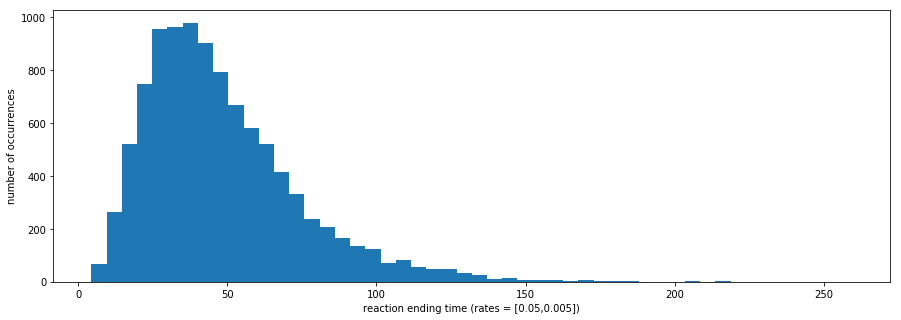

In [15]:
plt.hist(endTime, bins =50)
plt.ylabel('number of occurrences')
plt.xlabel('reaction ending time (rates = [0.05,0.005])') 
plt.show()

Let us import `simulate` which extracts mean of the trajectories that satisfy the following logic requirement:
_the disease ended between 100 and 120 unit of time (i.e., F[100,120] (I==0))_

Briefly,  simulate extract statistics from `endTime`


................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

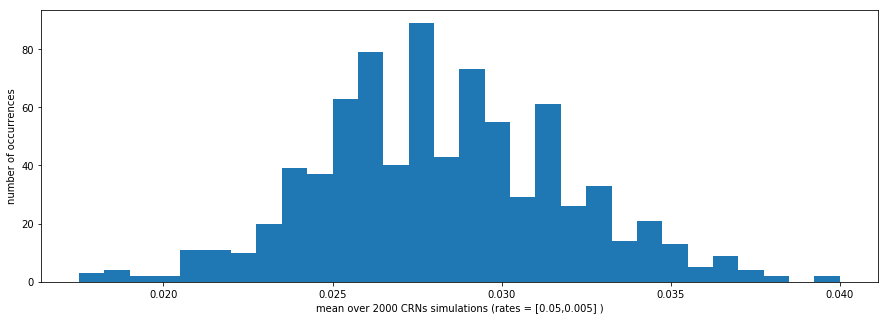

In [16]:
from pycheck.regressor.simulate import simulate
number_of_runs = 2000
phi = lambda x: simulate([0.05, x], number_of_runs) # the first rate has been fixed to 0.05

a = [phi(0.005) for i in range(800)]

#plot a bar chart
plt.hist(a, bins = 30)
plt.ylabel('number of occurrences')
plt.xlabel('mean over 2000 CRNs simulations (rates = [0.05,0.005] )')
plt.show()

### We report the cases discussed in [TACAS18]((https://link.springer.com/chapter/10.1007/978-3-319-89963-3_23))

In [10]:
from pycheck.regressor.simulate import simulate
from pycheck.tessellation.Tessellation import TessellationThreshold1D, TessellationThreshold2D
from pycheck.regressor.BayesianRegressor import EP


def case1():
    volumeEps = 0.1
    threshold = 0.1
    beta = 3
    model = EP()
    model.setScale(1000)
    trajectoriesNumber = 1000
    domain = [0.005, 0.3]
    fun = lambda x: simulate([0.05, x], trajectoriesNumber)
    tas = TessellationThreshold1D(domain, fun, model, beta, threshold, volumeEps)
    model = tas.tessellation()

def case2():
    volumeEps = 0.1
    threshold = 0.1
    beta = 3
    model = EP()
    model.setScale(1000)
    trajectoriesNumber = 1000
    #timeEnd = 125
    domain = [0.005, 0.2]
    fun = lambda x: simulate([x, 0.12], trajectoriesNumber)
    tas = TessellationThreshold1D(domain, fun, model, beta, threshold, volumeEps)
    tas.tessellation()


def case3():
    volumeEps = 0.1
    threshold = 0.1
    beta = 3
    model = EP()
    model.setScale(1000)
    trajectoriesNumber = 1000
    #timeEnd = 125
    domain = [[0.005, 0.005], [0.2, 0.3]]
    fun = lambda x: simulate(x, trajectoriesNumber)
    tas = TessellationThreshold2D(domain, fun, model, beta, threshold, volumeEps)
    tas.tessellation()

def accuracyCase1():
    volumeEps = 0.1
    threshold = 0.1
    beta = 3
    model = EP()
    model.setScale(1000)
    trajectoriesNumber = 1000
    #timeEnd = 125
    domain = [0.005, 0.3]
    fun = lambda x: simulate([0.05, x], trajectoriesNumber)
    tas = TessellationThreshold1D(domain, fun, model, beta, threshold, volumeEps)
    model,xs = tas.tessellation()
    testGrid = np.linspace(0.01, 0.07, num=300)
    accurateFunction = lambda x: simulate([0.05, x], 10000)

    accurateValues = [accurateFunction(e) for e in testGrid]
    estimated = [model.getEvaluator().confidenceBounds(e, 3) for e in testGrid]

    count = 0
    for i in range(len(accurateValues)):
        if (estimated[i][0] > threshold and accurateValues[i] < threshold):
            count = count + 1
        elif (estimated[i][1] < threshold and accurateValues[i] > threshold):
            count = count + 1
    print("Missclassifed Points:" + str(count*100 / len(accurateValues))+"%")
    print("______________________________________________")


def derivativeCase1():
    volumeEps = 0.1
    threshold = 0.1
    beta = 3
    model = EP()
    model.setScale(1000)
    trajectoriesNumber = 1000
    # timeEnd = 125
    domain = [0.005, 0.3]
    fun = lambda x: simulate([0.05, x], trajectoriesNumber)
    tas = TessellationThreshold1D(domain, fun, model, beta, threshold, volumeEps)
    m, xs = tas.tessellation()
    lbub = m.getEvaluator().confidenceBounds(xs[:, None], 2)
    """
    METHOD 1: LOCAL LISPSCHITZ BOUND
    """
    localDerivativeLB = lbub[0][1:] - lbub[0][:-1]
    localDerivativeUB = lbub[1][1:] - lbub[1][:-1]
    """
    METHOD 2: GLOBAL LISPSCHITZ BOUND
    """
    globalDerivativeLB = max(localDerivativeLB)
    globalDerivativeUB = max(localDerivativeUB)

    lbub = m.getEvaluator().confidenceBounds(xs[:, None], 3)
    changeStatus = 0
    for i in range(len(xs) - 1):
        if (lbub[0][i] > threshold and lbub[0][i] - localDerivativeLB[i] < threshold):
            changeStatus = changeStatus + 1
        elif (lbub[1][i] < threshold and lbub[1][i] + localDerivativeUB[i] > threshold):
            changeStatus = changeStatus + 1

    print("LOCAL LISPSCHITZ (points changing status):" + str(changeStatus * 100 / (len(xs) - 1)) + "%")
    print("______________________________________________")

    changeStatus = 0
    for i in range(len(xs) - 1):
        if (lbub[0][i] > threshold and lbub[0][i] - globalDerivativeLB < threshold):
            changeStatus = changeStatus + 1
        elif (lbub[1][i] < threshold and lbub[1][i] + globalDerivativeUB > threshold):
            changeStatus = changeStatus + 1
    print("GLOBAL LISPSCHITZ (points changing status):" + str(changeStatus * 100 / (len(xs) - 1)) + "%")
    print("______________________________________________")



### Let us see in details case1()

In [11]:
def case1():
    volumeEps = 0.1   # this is the maximum valume (of paramter space) where we do not know if the probability is below or above the threshold (yellow area in charts) 
    threshold = 0.1   # this is the threshold
    beta = 3
    model = EP()      # expected propagation approach (this is where smoothed model checking plays its role)
    model.setScale(1000)
    trajectoriesNumber = 1000 # how many simulation we want to performs
    domain = [0.005, 0.3]     # paramter domain bounds
    fun = lambda x: simulate([0.05, x], trajectoriesNumber)
    tas = TessellationThreshold1D(domain, fun, model, beta, threshold, volumeEps)
    model = tas.tessellation()

### Let us simply recal them.

........................................

/home/ssilvetti/git/pyCheck/pycheck/regressor/EP.py:161: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "gausshermite" failed type inference due to: non-precise type pyobject
[1] During: typing of argument at /home/ssilvetti/git/pyCheck/pycheck/regressor/EP.py (163)

File "../regressor/EP.py", line 163:
    def gausshermite(self, n, x, w):
        x0 = np.zeros(shape=(len(x), 1))
        ^

  @jit
/home/ssilvetti/git/pyCheck/pycheck/regressor/EP.py:161: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "gausshermite" failed type inference due to: cannot determine Numba type of <class 'numba.dispatcher.LiftedLoop'>

File "../regressor/EP.py", line 173:
    def gausshermite(self, n, x, w):
        <source elided>
        np_sqrt = np.sqrt(sqrt)
        for i in range(0, m):
        ^

  @jit
/home/ssilvetti/miniconda3/lib/python3.6/site-packages/numba/object_mode_passes.py:178: Numba

RBF(length_scale=0.0147)
....................RBF(length_scale=0.0147)
....................RBF(length_scale=0.0147)
....................RBF(length_scale=0.0147)
....................RBF(length_scale=0.0147)
Execution Time:14.635884761810303


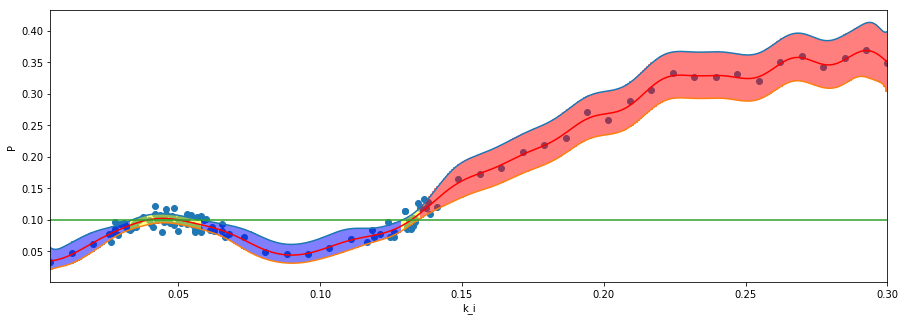

In [12]:
case1()

........................................RBF(length_scale=0.00975)
Execution Time:3.092829942703247


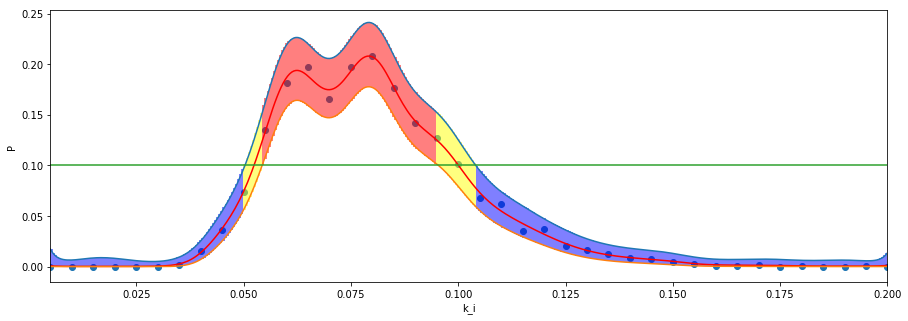

In [13]:
case2()

................................................................................................................................................................................................................................................................................................................................................................................................................RBF(length_scale=0.0123)
...................................................................................................RBF(length_scale=0.0123)
...................................................................................................RBF(length_scale=0.0123)
...................................................................................................RBF(length_scale=0.0123)
...................................................................................................RBF(length_scale=0.0123)
...............................................................................

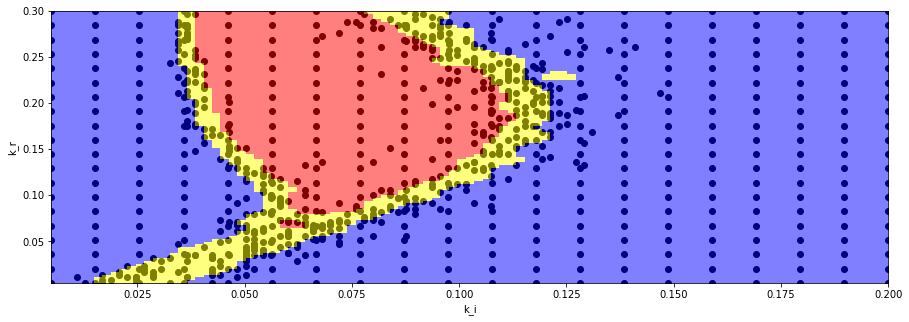

In [14]:
case3()